# Clasificación de olvia

In [3]:
import numpy as np
import pandas as pd

In [4]:
modes_df  = pd.read_csv('dataset_panoradio_hf_tags.csv')
signal_matrix = np.load('dataset_panoradio_hf.npy')
modes_df.drop(columns=['idx'], inplace=True)

In [10]:
modes = modes_df[' mode'].unique()

olivia_modes = list(set(m for m in modes if 'olivia' in m))

olivia_mode_mask = modes_df[' mode'].isin(olivia_modes)
olivia_modes_df = modes_df[olivia_mode_mask]
olivia_signals = signal_matrix[olivia_mode_mask]

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_modes = le.fit_transform(olivia_modes_df[' mode'])

## Distinción mediante FFT

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(
    np.log(np.abs(np.fft.fft(olivia_signals)) + 1e-127), y_modes,
    random_state=42,
    test_size=0.4,
    stratify=y_modes,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val,
    random_state=42,
    test_size=0.5,
    stratify=y_test_val,
)

In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    # --- TUS PARÁMETROS ORIGINALES ---
    n_estimators=2000,
    learning_rate=0.05,
    
    # Frenos de complejidad (INTACTOS)
    max_depth=4,
    min_child_weight=3,
    
    # Frenos de aleatoriedad (INTACTOS)
    subsample=0.7,
    colsample_bytree=0.3,
    
    # Regularización matemática (INTACTA)
    gamma=1,
    reg_alpha=5,
    reg_lambda=10,

    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=50,
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

[0]	validation_0-mlogloss:1.36948	validation_1-mlogloss:1.37057
[50]	validation_0-mlogloss:0.93146	validation_1-mlogloss:0.96274
[100]	validation_0-mlogloss:0.74378	validation_1-mlogloss:0.79544
[150]	validation_0-mlogloss:0.62434	validation_1-mlogloss:0.69221
[200]	validation_0-mlogloss:0.54626	validation_1-mlogloss:0.62746
[250]	validation_0-mlogloss:0.48562	validation_1-mlogloss:0.57982
[300]	validation_0-mlogloss:0.44084	validation_1-mlogloss:0.54674
[350]	validation_0-mlogloss:0.40233	validation_1-mlogloss:0.52012
[400]	validation_0-mlogloss:0.37233	validation_1-mlogloss:0.50167
[450]	validation_0-mlogloss:0.34308	validation_1-mlogloss:0.48343
[500]	validation_0-mlogloss:0.31924	validation_1-mlogloss:0.46954
[550]	validation_0-mlogloss:0.29927	validation_1-mlogloss:0.45903
[600]	validation_0-mlogloss:0.28178	validation_1-mlogloss:0.45111
[650]	validation_0-mlogloss:0.26534	validation_1-mlogloss:0.44308
[700]	validation_0-mlogloss:0.25075	validation_1-mlogloss:0.43629
[750]	validat

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, classes=None):

    y_pred = model.predict(X_test)

    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(8, 8))

    disp.plot(cmap=plt.cm.Blues, im_kw={'vmin': 0, 'vmax': 1})

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=90) # Rotar etiquetas eje X
    plt.yticks(rotation=0)  # Mantener etiquetas eje Y horizontales

<Figure size 800x800 with 0 Axes>

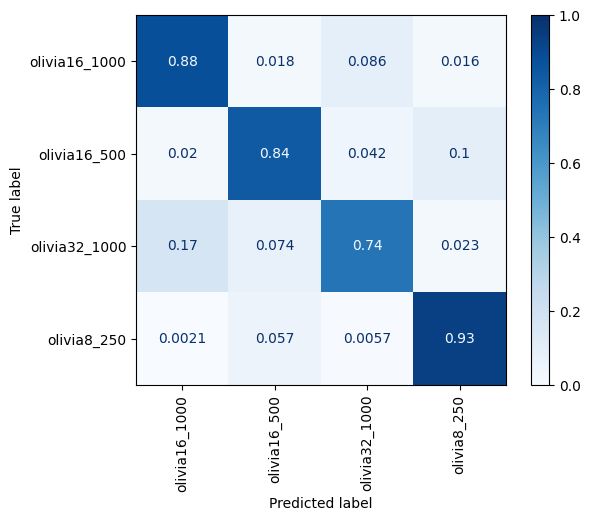

In [18]:
plot_confusion_matrix(xgb, X_test, y_test, classes=le.classes_)

In [19]:

from pathlib import Path
import joblib

PATH = Path(r'C:\Users\gsus\Documents\uni\inteligencia en red\trabajo final')
MODEL_PATH = PATH / 'modelos'

joblib.dump(le, MODEL_PATH / 'entre_olivia_encoder.joblib')
joblib.dump(xgb, MODEL_PATH / 'entre_olivia_modelo.joblib')

['C:\\Users\\gsus\\Documents\\uni\\inteligencia en red\\trabajo final\\modelos\\entre_olivia_modelo.joblib']